In [1]:

import einops
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

import cv2

In [2]:
#https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py
#https://pythonawesome.com/explainability-for-vision-transformers-in-pytorch/
#https://github.com/hila-chefer/Transformer-MM-Explainability/blob/main/Transformer_MM_explainability_ViT.ipynb
#https://jacobgil.github.io/deeplearning/vision-transformer-explainability#gradient-attention-rollout-for-class-specific-explainability
#https://arxiv.org/pdf/2012.09838v1.pdf

In [4]:
from pathlib import Path

# Prepare Model
#config = CONFIGS["ViT-B_16"]
config = CONFIGS["R50-ViT-B_16"]
model = VisionTransformer(config, num_KPs=24, zero_head=False, img_size=224, vis=True)
checkpoint_path = Path()
# Define the path in an OS-independent way
checkpoint_path = Path("projects") / "Facemap" / "output" / "facemap_ViT_ResNet_w_data_augmentation_checkpoint_epoch_299.pth"
#checkpoint_path = Path("projects") / "Facemap" / "output" / "facemap_without_augmentation_300epochs_testing20240907.pth"
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))  # Load the checkpoint #delete map_location=torch.device('cpu') if run on GPU
model.load_state_dict(checkpoint['state_dict'])
print(model)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])



VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (hybrid_model): ResNetV2(
        (root): Sequential(
          (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (gn): GroupNorm(32, 64, eps=1e-06, affine=True)
          (relu): ReLU(inplace=True)
          (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (body): Sequential(
          (block1): Sequential(
            (unit1): PreActBottleneck(
              (gn1): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (gn2): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (gn3): GroupNorm(32, 256, eps=1e-06, affine=True)
              (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fa

# Showing model predictions on an image (single forward pass)

Input tensor size: torch.Size([1, 197, 768])


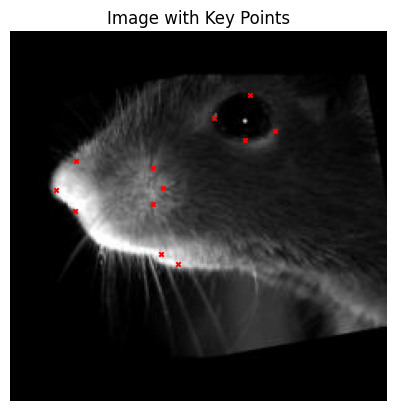

In [7]:
from pathlib import Path
from PIL import Image

# Define the data path in an OS-independent way
data_path = Path("projects") / "Facemap" / "data" / "test" / "augmented_data"

# Define the image name
imageName = 'cam1_G7c1_1_img9130_rotate_rescale_augmented.jpg'

# Open the image (using the / operator to concatenate the path and file name)
im = Image.open(data_path / imageName)

# Transform the image (assuming you have a transform function defined)
x = transform(im)

# Get model output
# Assuming the model is already defined and loaded
out = model(x.unsqueeze(0))

# Convert the model output to a format suitable for plotting
keypoints = out[0].detach().cpu().numpy()  # Detach and move to CPU if using a GPU

# Plot the image
plt.imshow(im)

# Access the first row of keypoints since shape is (1, 24)
keypoints = keypoints[0]

# Loop through the keypoints and plot them
for i in range(0, len(keypoints), 2):
    x_coord = keypoints[i]
    y_coord = keypoints[i + 1]
    plt.scatter(x_coord, y_coord, s=10, c='red', marker='x')  # Plot each keypoint

plt.title("Image with Key Points")
plt.axis('off')  # Turn off axis labels
plt.show()


In [18]:
print(keypoints)

[154.88947   44.213432 133.55956   55.760735 150.68288   72.48452
 169.01135   67.613716  44.541763  63.464794  32.05732   76.84995
  39.9314    92.40256   89.1303    89.63295   90.99373   78.06154
  88.54173  101.238884  81.90758  130.52077   92.37673  138.55548 ]


# Code for trying to plot one key point, and try out different discard ratios (to filter out 'noise' in the attention map plot)



C:\Users\avs20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Input tensor size: torch.Size([1, 197, 768])


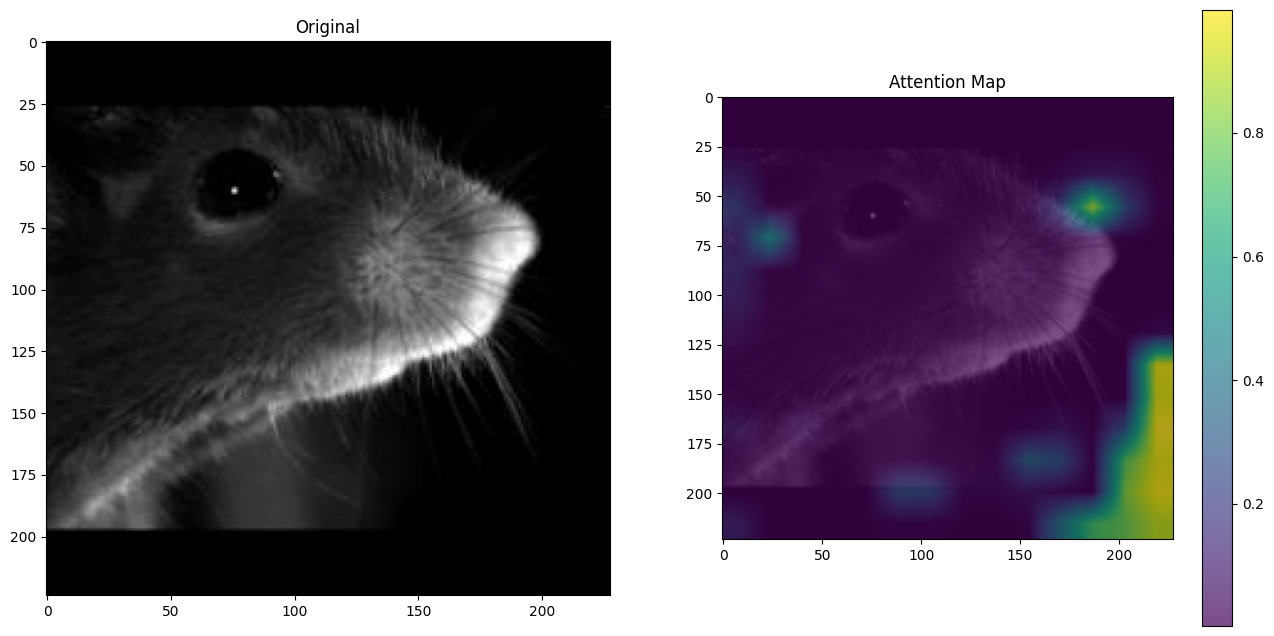

Input tensor size: torch.Size([1, 197, 768])


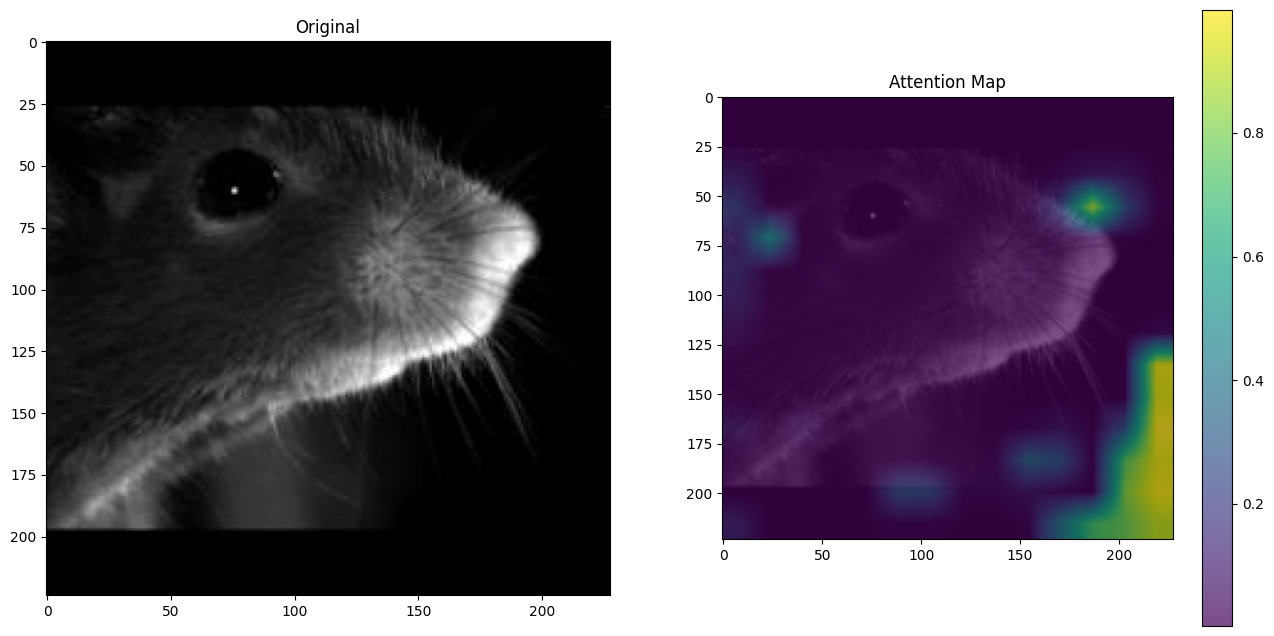

Input tensor size: torch.Size([1, 197, 768])


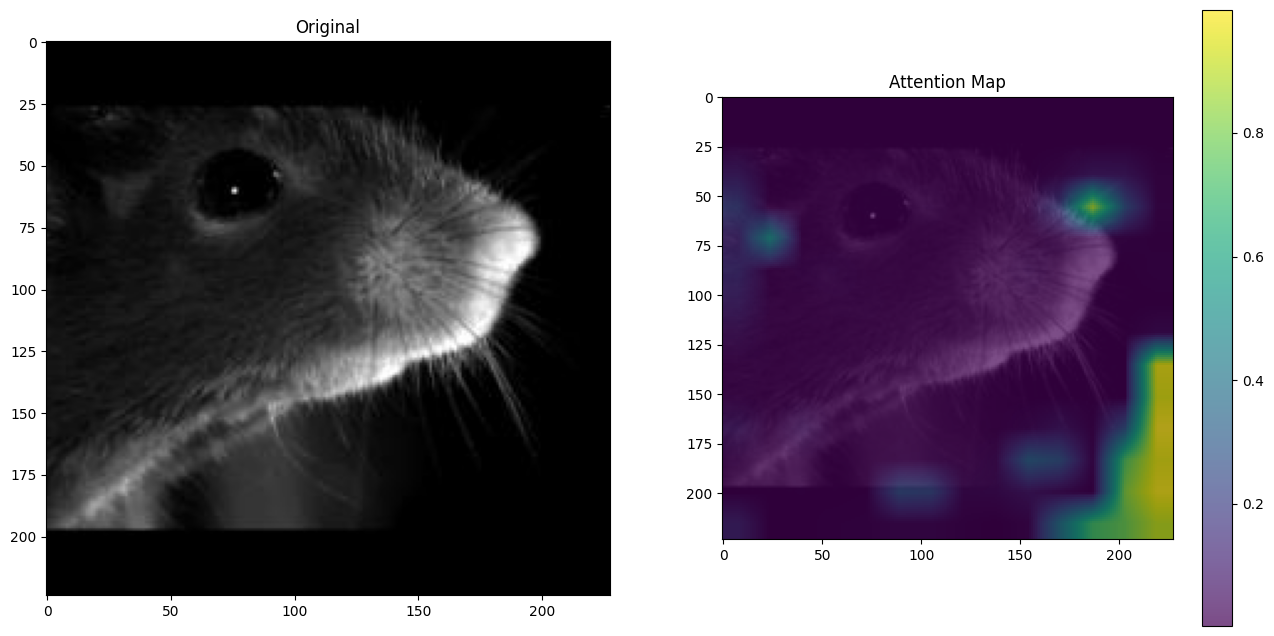

Input tensor size: torch.Size([1, 197, 768])


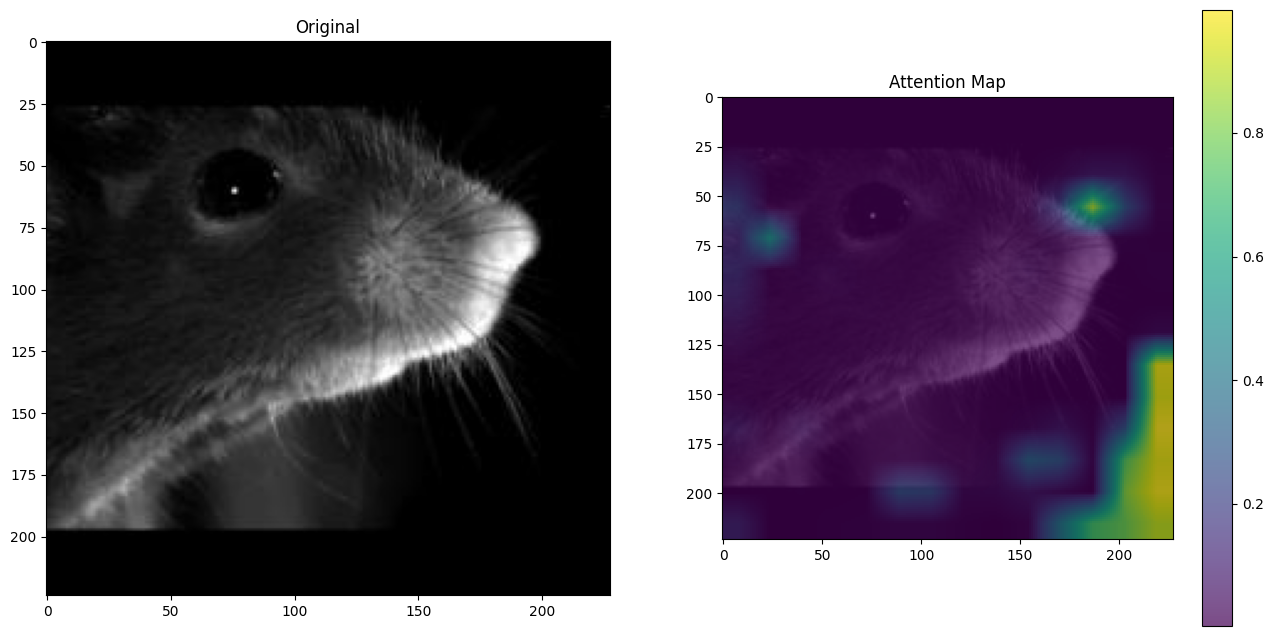

Input tensor size: torch.Size([1, 197, 768])


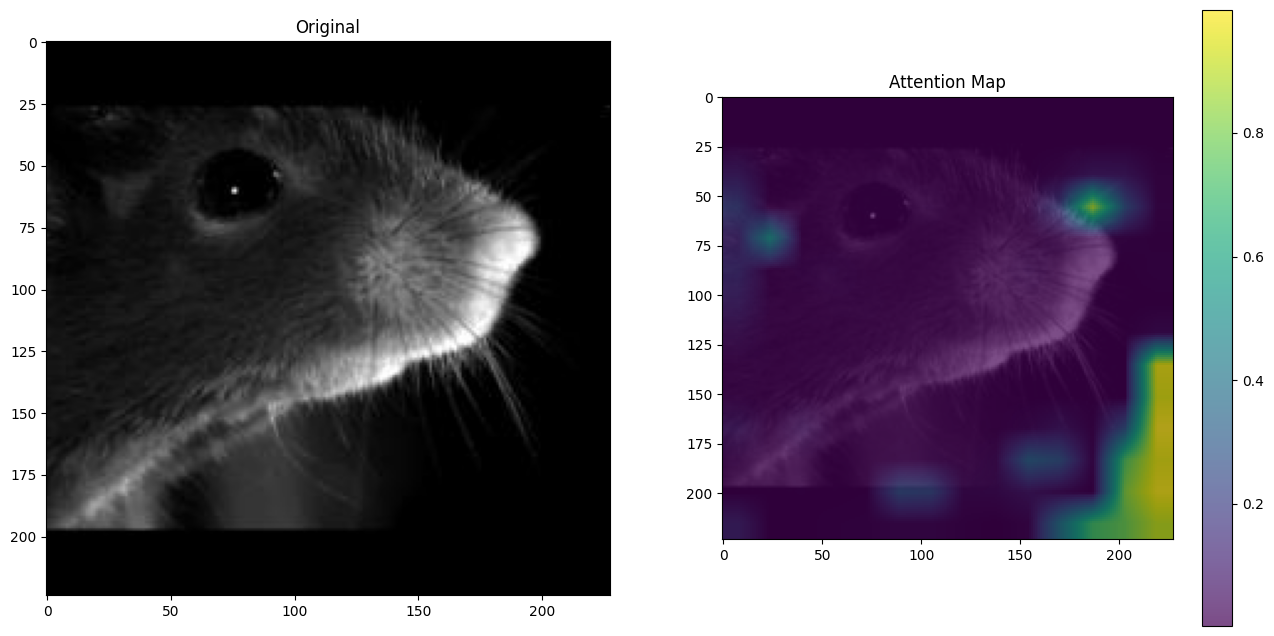

In [5]:
#This code is based on LINKS
# https://jacobgil.github.io/deeplearning/vision-transformer-explainability - repo for concept
# https://github.com/jacobgil/vit-explain/tree/main - code repo

from attention_map_visualization.vit_grad_rollout import VITAttentionGradRollout

transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
image = Image.open("augmented_data_test/img8504_flip_rescale_augmented.jpg")
x = transform(image)
x.size()

#config = CONFIGS["ViT-B_16"]
#model = VisionTransformer(config, num_classes=24, zero_head=False, img_size=224, vis=True)
for i in [0.0,0.2,0.5,0.7,0.9]:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=i) # read up on discard ratio
    mask = grad_rollout(x.unsqueeze(0), category_index=0) #I think it does a forward and backward pass using the model to find out what image areas are important for the KP in question #+ grad_rollout(x.unsqueeze(0), category_index=23) # change category index for different key points - 0:23
    np_img = np.array(image)[:, :, ::-1]
    mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
    #mask = mask / np.max(mask)


    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    # Display the original image
    ax1.imshow(image)
    # Display the attention map as a heatmap
    ax2.imshow(image)
    cax = ax2.imshow(mask, cmap='viridis', interpolation='nearest', alpha=0.7)
    fig.colorbar(cax, ax=ax2, orientation='vertical', shrink=0.5)
    plt.show()

#/Users/annastuckert/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior. warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "

# Code for plotting attention map for each keypoint seperately (but plotting for the x+y coordinates jointly) - unsure if it works

## Beware the plots here utilize the key points predicted during training, NOT the key points gained from doing a forward pass with the model here.

C:\Users\avs20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


IndexError: list index out of range

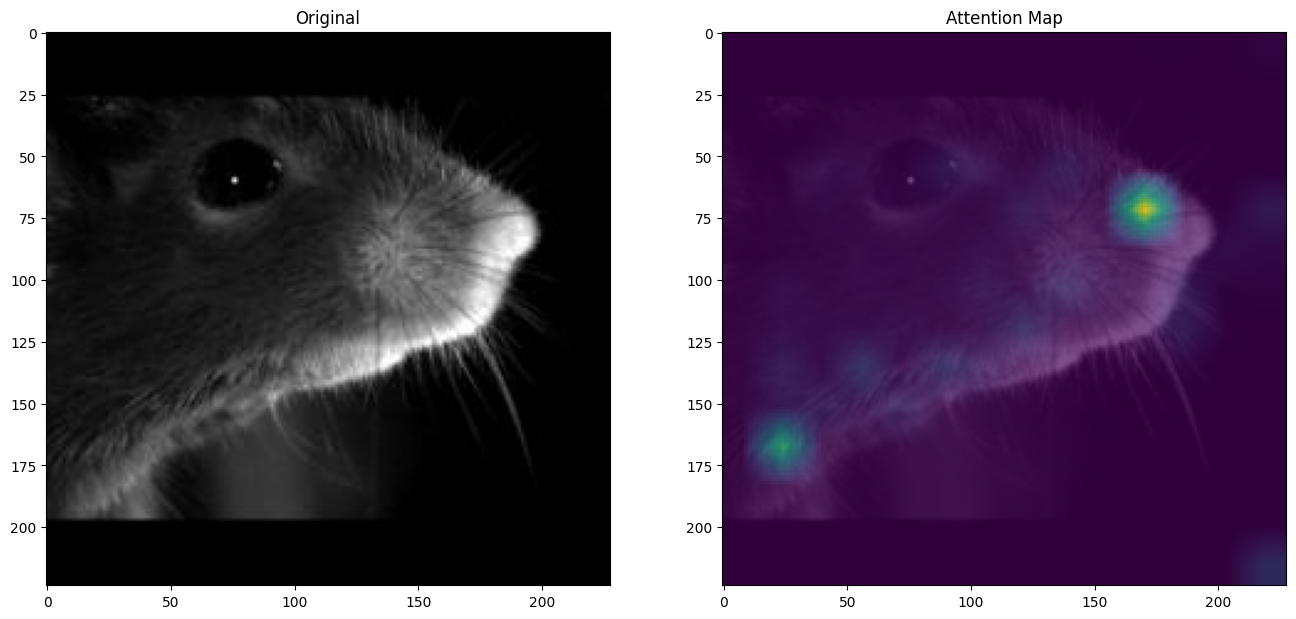

In [13]:
# Display the original image and attention map
#keypoints = [74.13194083494960, 42.812873202013800, 95.30841192338180, 56.58447399279880, 78.44566642703760, 72.3234463251248, 60.40645031466930, 66.42133170050260, 188.64174746128700,	65.6343830838861, 197.6613555174720,	82.94725264944450,	189.81821807731100,	91.21021312391570,	137.26919722823800,	90.81673881560770,	141.19076594831900,	77.43861233313060,	133.3476285081590,	105.37528822300900,	145.11233466839900,	129.77069533811400,	138.0535109722550,	136.85323288766000]
#Here I have manually inserted the key points for the image we are investigating

#imageName = 'img6725_rotate_rescale_augmented.jpg'
imageName = 'img8819_flip_rescale_augmented.jpg'
im = Image.open("augmented_data_test/" + imageName)
x = transform(im)
x.size()

labels = pd.read_csv(data_path /'augmented_labels.csv')
labelsKepoints = labels.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:]

preds = pd.read_csv('predictions.csv')
predsKeypoints = preds.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:-1]
from attention_map_visualization.vit_grad_rollout import VITAttentionGradRollout

for i in range(0, 23, 2): #so it starts at index 0 (keypoint 0, allegedly), goes to index 23 (keypoint 23, allegedly), and moves 2 keypoints for each step
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.0)
    mask = grad_rollout(x.unsqueeze(0), category_index=i) + grad_rollout(x.unsqueeze(0), category_index=i+1) #should plot the attention maps for category_index=i+1, so the keypoint in question (x coordinate), and the following one (corresponding y coordinate)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    ax1.set_title('Original')
    ax2.set_title('Attention Map')

    # Display the original image
    ax1.imshow(im)

    # Display the attention map as a heatmap
    ax2.imshow(im)
    np_img = np.array(im)[:, :, ::-1]
    mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
    ax2.imshow(mask, cmap='viridis', interpolation='nearest', alpha=0.7)

    #ax1.plot(labelsKepoints[i], labelsKepoints[i+1], 'ro') #allows us to plot x+y coordinate of each key point (i+1) and loops over the 24 keypoints, skipping every second step since we plot both x+y 
    #ax2.plot(labelsKepoints[i], labelsKepoints[i+1], 'ro')

    ax1.plot(predsKeypoints[i], predsKeypoints[i+1], 'yo', markerfacecolor='none', markersize=10) #allows us to plot x+y coordinate of each key point (i+1) and loops over the 24 keypoints, skipping every second step since we plot both x+y 
    ax2.plot(predsKeypoints[i], predsKeypoints[i+1], 'yo', markerfacecolor='none', markersize=10)
    
    fig.colorbar(cax, ax=ax2, orientation='vertical', shrink=0.5)
    ax2.imshow(mask)
    cax = ax2.imshow(mask, cmap='viridis', interpolation='nearest', alpha=0.7)
    fig.colorbar(cax, ax=ax2, orientation='vertical')

    plt.show()


# I think from here it is the original attention map code (modified to show my images)

In [ ]:
print(model(x.unsqueeze(0)))

In [ ]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Assuming att_mat is obtained from your model
logits, att_mat = model(x.unsqueeze(0))
att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

In [ ]:
# Display the original image and attention map
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')

# Display the original image
ax1.imshow(im)

# Display the attention map as a heatmap
ax2.imshow(im)
cax = ax2.imshow(mask, cmap='viridis', interpolation='nearest', alpha=0.7)
fig.colorbar(cax, ax=ax2, orientation='vertical')

plt.show()

### Reference
* [attention_flow](https://github.com/samiraabnar/attention_flow)
* [vit-keras](https://github.com/faustomorales/vit-keras)

Input tensor size: torch.Size([1, 197, 768])
tensor([[[[5.1824e-10, 9.3835e-10, 5.1245e-13,  ..., 6.4099e-12,
           3.4982e-12, 1.0222e-12],
          [5.3219e-01, 3.2085e-06, 1.2750e-02,  ..., 5.9819e-07,
           7.2899e-08, 8.0750e-07],
          [3.5270e-02, 3.5345e-07, 2.9617e-02,  ..., 2.0064e-05,
           7.5557e-06, 6.9614e-05],
          ...,
          [1.4312e-08, 4.9686e-05, 1.8223e-01,  ..., 1.3054e-04,
           5.5610e-06, 1.3787e-07],
          [8.9947e-07, 2.5672e-03, 6.0321e-02,  ..., 2.1112e-03,
           3.0499e-04, 1.6748e-05],
          [2.5296e-06, 1.7396e-07, 2.1464e-10,  ..., 1.0013e-08,
           2.8959e-08, 1.6295e-07]],

         [[9.5314e-01, 6.9600e-12, 1.3253e-10,  ..., 9.2921e-09,
           3.3370e-07, 3.3221e-04],
          [9.9998e-01, 1.0893e-08, 3.1243e-10,  ..., 1.7959e-08,
           1.4641e-08, 3.0879e-08],
          [9.9964e-01, 5.7734e-07, 5.2310e-07,  ..., 2.0706e-07,
           9.7384e-08, 1.1762e-07],
          ...,
          [1.0

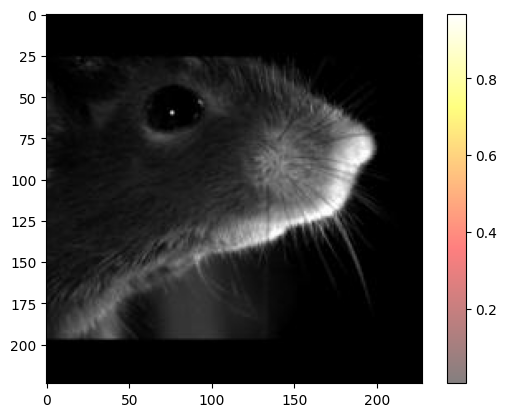

In [14]:
# Assuming att_mat is obtained from your model
#logits, att_mat = model(x.unsqueeze(0)) # logits kunne vaere predictions, hvor kommer 197 fra?
logits, att_mat = model.forward(x.unsqueeze(0))
att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)

# Create a heatmap using 'hot' colormap
heatmap = plt.imshow(mask, cmap='hot', interpolation='nearest')

# Apply alpha channel to the heatmap
heatmap.set_alpha(0.5)

# Display the original image
plt.imshow(im)

# Show the colorbar
plt.colorbar(heatmap)

plt.show()

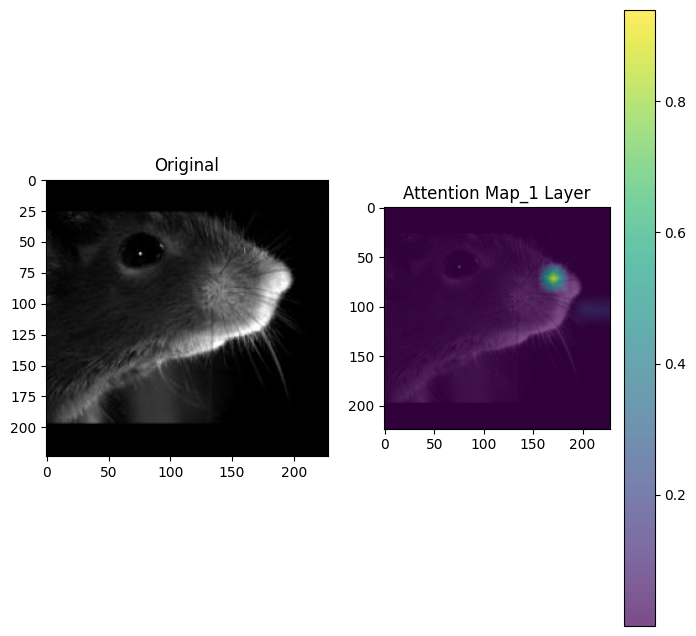

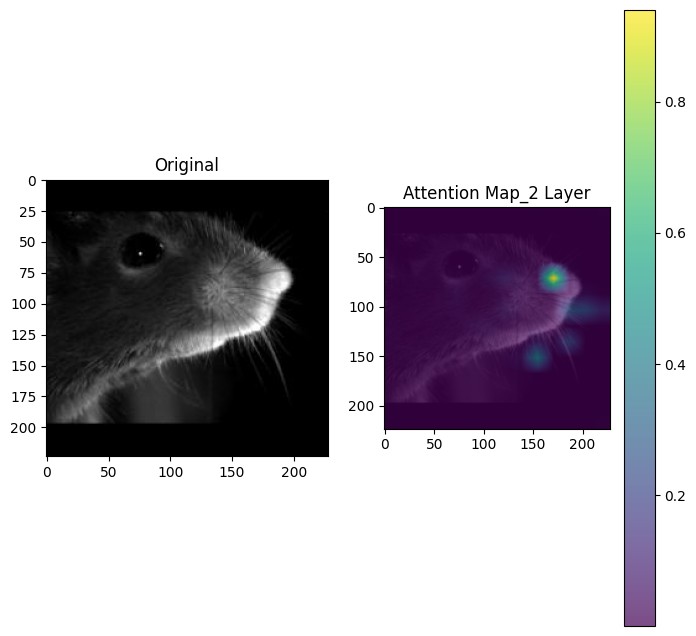

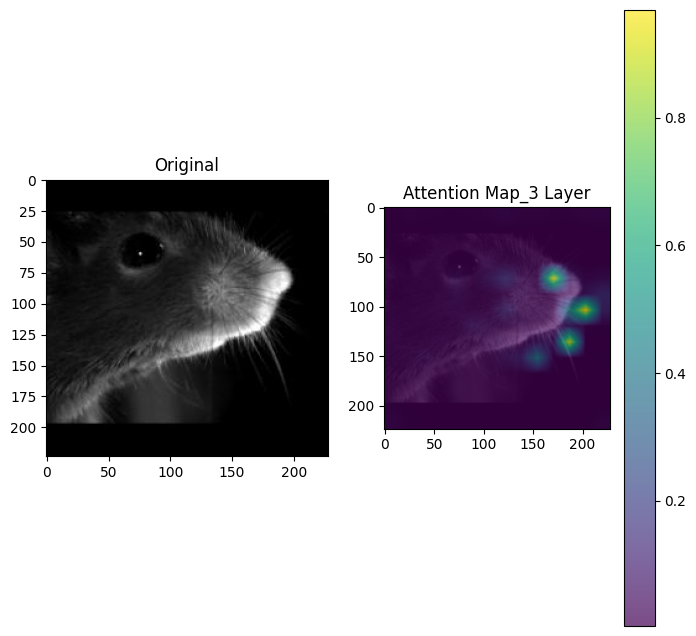

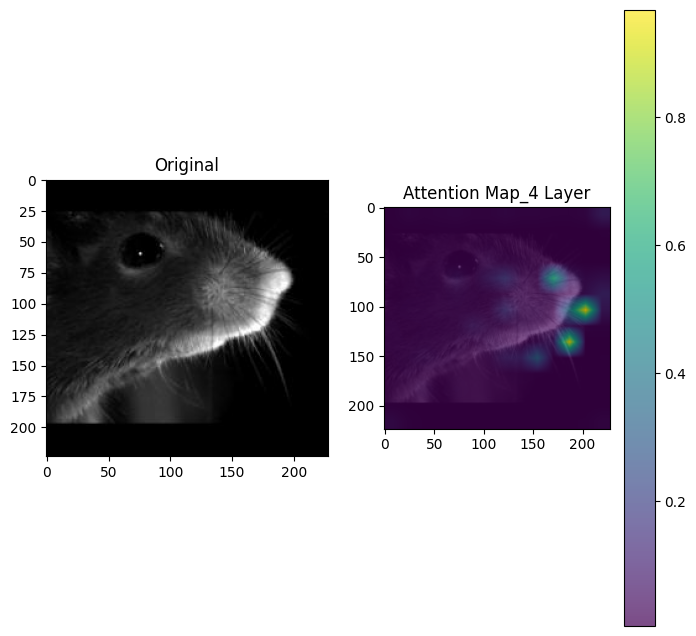

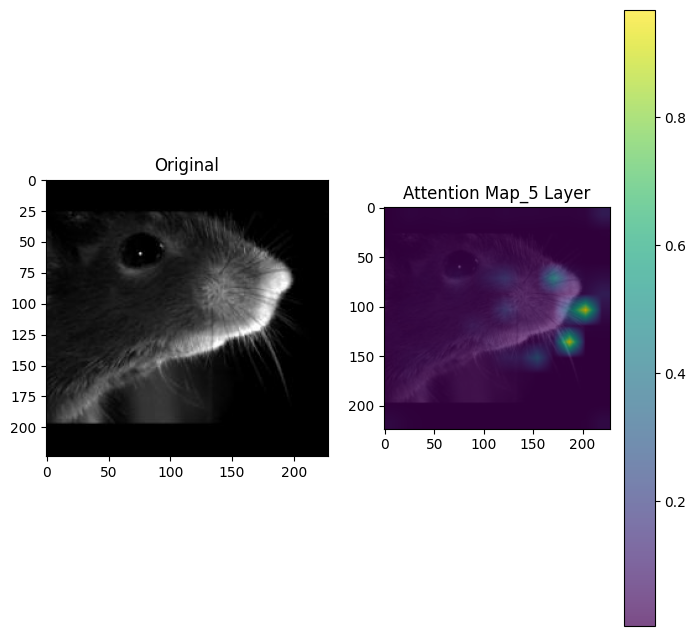

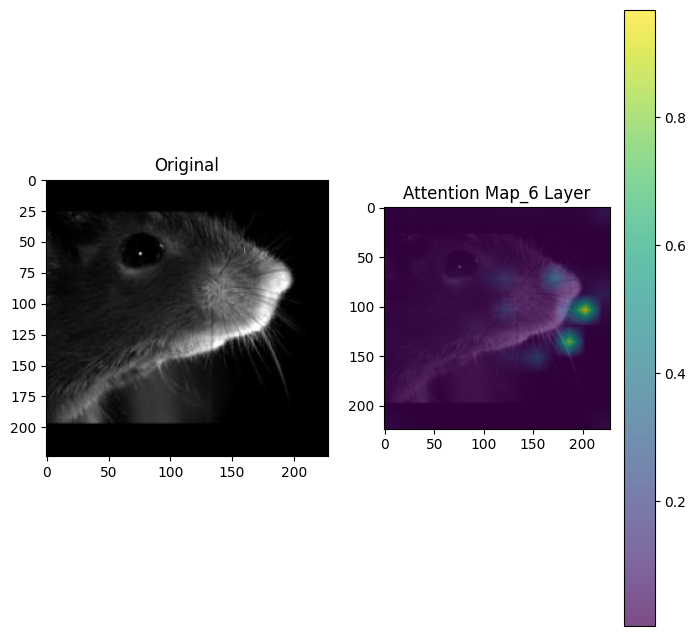

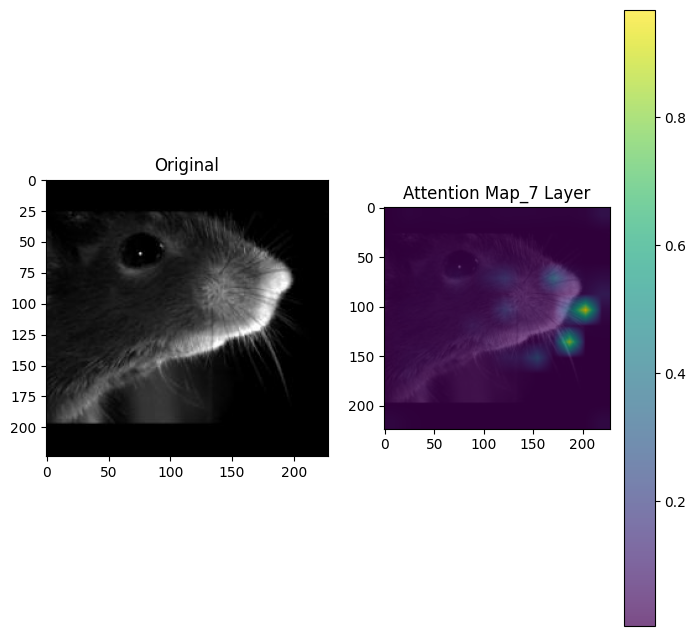

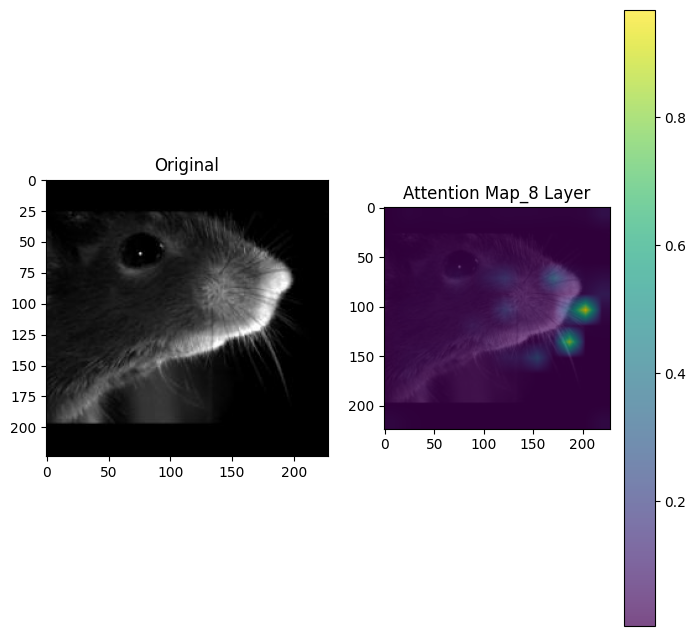

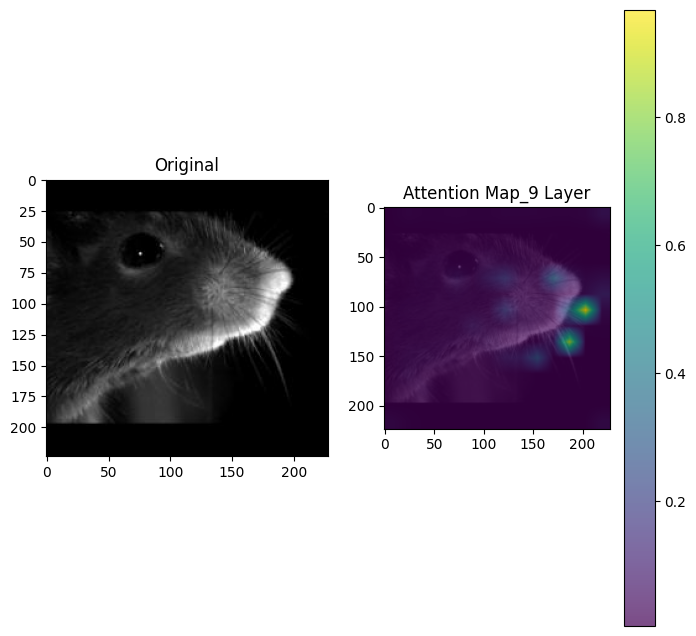

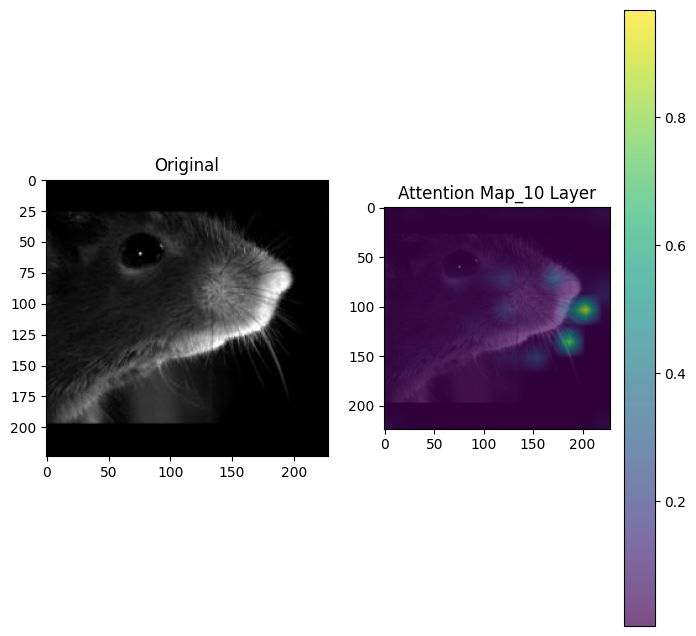

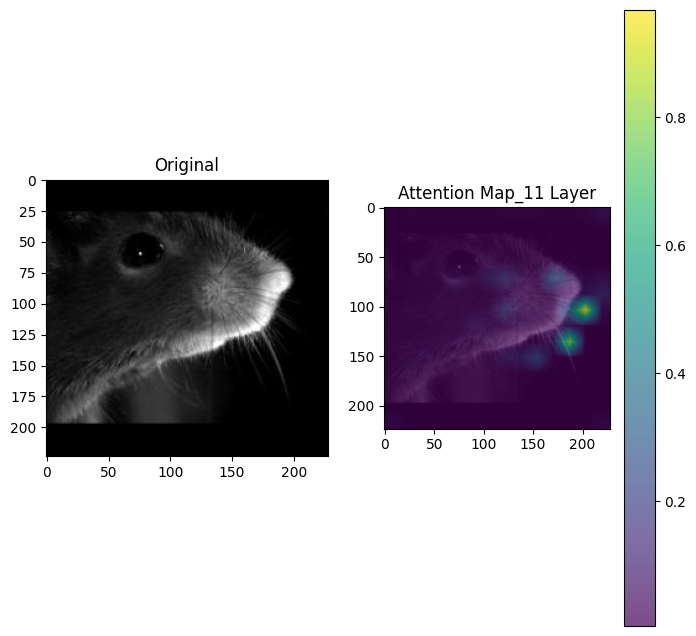

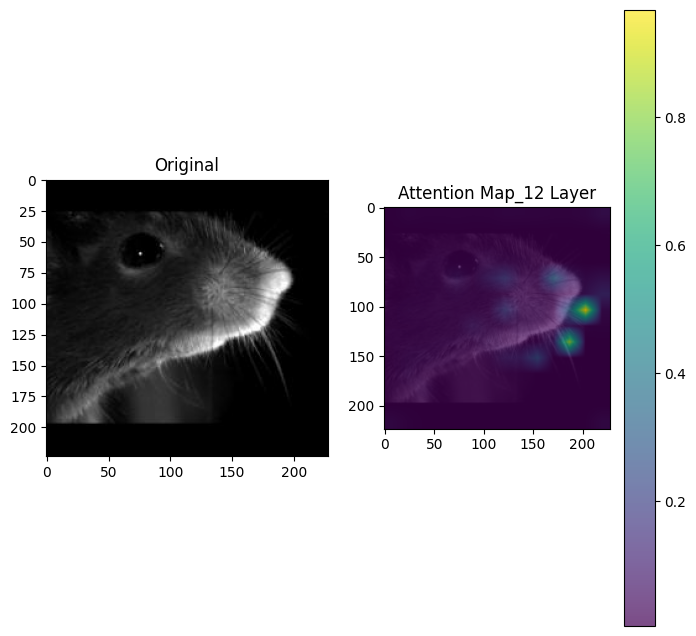

In [15]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(im)
    _ = ax2.imshow(im)
    cax = ax2.imshow(mask, alpha=.7, cmap = 'viridis')
    fig.colorbar(cax, ax=ax2, orientation='vertical')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


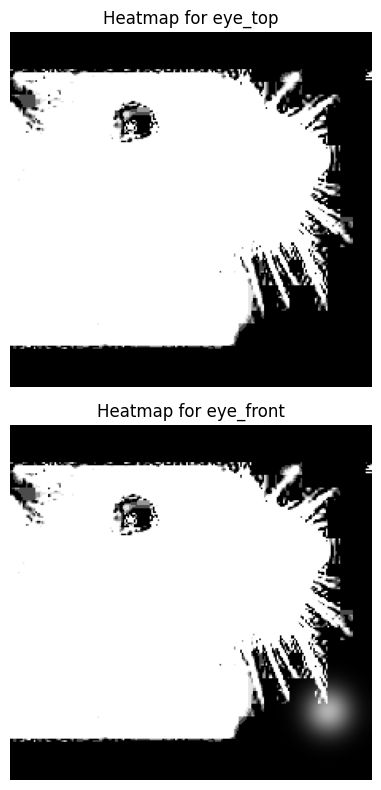

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Function to calculate attention map for a key point
def calculate_attention_map(keypoint_data, image_shape):
    # Generate a blank image with the same shape as the original image
    attention_map = np.zeros(image_shape[:2], dtype=np.float32)
    
    # Extract key point coordinates
    x, y = keypoint_data
    
    # Set the attention value at the key point location
    attention_map[y, x] = 1.0  # You might need to adjust the indexing based on the format of your key point data
    
    # Apply Gaussian blur to smoothen the attention map
    attention_map = gaussian_filter(attention_map, sigma=10)  # Adjust the sigma value as needed
    
    # Normalize attention map to [0, 1]
    attention_map = attention_map / np.max(attention_map)
    
    return attention_map

# Function to overlay attention map on original image with transparency
def overlay_attention_map(image, attention_map, alpha=0.7):
    # Convert attention map to 3-channel image
    attention_map = np.expand_dims(attention_map, axis=2)
    attention_map = np.tile(attention_map, (1, 1, 3))
    
    # Apply transparency to attention map
    overlay = image.copy()
    overlay = cv2.addWeighted(overlay.astype(np.float32), 1 - alpha, attention_map, alpha, 0)
    
    return overlay

# Load original image
original_image = cv2.imread("augmented_data_test/img8504_flip_rescale_augmented.jpg")  # Replace "original_image.jpg" with the path to your original image

# Define the coordinates of each key point
keypoints = {
    "eye_top": (100, 150),
    "eye_front": (200, 180),
    # Add more key points as needed
}

# Plot attention maps for each key point
plt.figure(figsize=(10, 8))
for idx, (key, keypoint_data) in enumerate(keypoints.items(), 1):
    # Calculate attention map for the current key point
    attention_map = calculate_attention_map(keypoint_data, original_image.shape)
    
    # Overlay attention map on original image
    overlaid_image = overlay_attention_map(original_image, attention_map)
    
    # Plot the overlaid image
    plt.subplot(2, len(keypoints)//2, idx)
    plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Heatmap for {key}")
    plt.axis("off")

plt.tight_layout()
plt.show()